\newpage

# Current frequency of threshold exceedance

In this chapter the current frequency of exceeding the threshold determined in Chapter 2 will be analysed. This is done by looking at the available observation data of the catchment area of the Wien River. The eWaterCycle platform provides access to this data from camels in Austria. As determined in Chapter 2, the Wien River is designed for a 1000-year discharge return period. The observation data is unlikely to cover a period of 1000 years, so the data will need to be extrapolated to be able to estimate the return period of the previously established threshold. 

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported.
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# eWaterCycle provides access to the Caravan dataset. This dataset contains data on rainfall, potential evaporation and discharge for all 
# the catchments in the different Camel datasets. The Caravan dataset contains a Camel dataset of the catchment of the Wien River. 
# This catchment area is loaded below:

camelsgb_id = "lamah_208082"

In [3]:
# The start and end date of the experiment need to be specified. The start and end date of the available observation data are determined further below
experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2020-12-31T00:00:00Z"

In [4]:
# The forcing data can be generated or previously generated data can be loaded:
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

# print(camelsgb_forcing)

## Observations

First of all, the available observation data will be investigated. This data is available from camels in Austria to which eWaterCycle provides access. This dataset contains data on precipitation, surface air temperature, potential evapotranspiration and discharge. The discharge observations can be seen in the graph in Figure 4 below. 

In [6]:
# The forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). 
# For determining the threshold exceedance frequency, only the discharge data are used. 
# The discharge data is loaded from the forcing below. The data contains the maximum discharge values per day.

ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q'], ])
# ds_forcing["Q"].plot()
# plt.title('Observed Discharge')
# plt.xlabel('Time (years)')
# plt.ylabel('Discharge (mm/day)')
# plt.text(0.2, -0.2, "Figure 1: Example Description", 
#          ha="center", fontsize=8, transform=plt.gca().transAxes)
# plt.show();

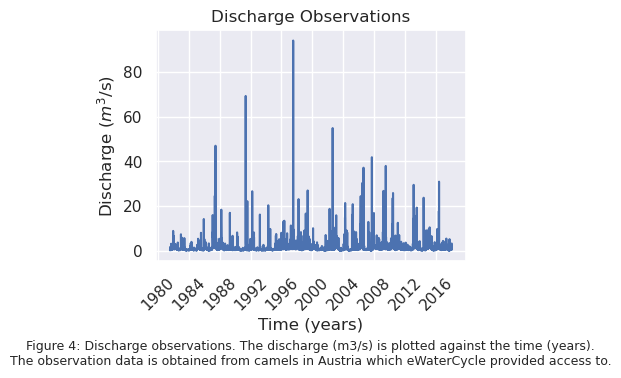

In [17]:
# Since the threshold values determined in chapter 2 are in m3/s, the observed discharge data, now in mm/d, is converted to m3/s as well.
plt.figure(figsize=(4, 3))
catchment_area = ds_forcing["area"].values

# go from mm/day to m3/s
discharge = []
for i in range(len(ds_forcing["Q"].values)):
    discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

x = ds_forcing["time"].values
y = discharge

plt.plot(x,y)
plt.xticks(rotation=45)
plt.xlabel('Time (years)')
plt.ylabel('Discharge ($m^3$/s)')
plt.title('Discharge Observations');
plt.text(0.5, -0.45, "Figure 4: Discharge observations. The discharge (m3/s) is plotted against the time (years).\n" 
"The observation data is obtained from camels in Austria which eWaterCycle provided access to.", 
         ha="center", fontsize=9, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/observations.png", dpi=300)

The observation data is available from 01-08-1981 to 01-01-2018, which covers a period of 36 years and 5 months. The highest peak present in this dataset has a discharge of 94.05 m\textsuperscript{3}/s. Since there is no peak present in this dataset with a discharge value of the threshold value for flooding, the observation data will need to be extrapolated.

## Extrapolation

The observation data is plotted in Figure 5 in the form of a scatter plot, with on the y-axis the discharge and on the x-axis the corresponding return period. The blue line is fitted through the observation data, and is extrapolated to find out the return period for the threshold value. 

The return periods corresponding to the discharges are calculated according to the Weibull equation with the following formula (Baaqeel et al., 2016):

$$ T = \frac{n + 1}{\text{Rank} \cdot 365.25} $$
T = return period in years\
n = total datapoints\
rank = position of datapoint in sorted data list


A line is fitted through the observation data with the power law function:

$$ f(x) = a \cdot x^b $$
parameters a and b are fitted with the curve_fit function from scipy.optimize.\
x represents the return periods


The fit 1 to fit 5 lines represent fitted lines where one or more of the observed data points are missing.

* fit 1 misses the highest peak
* fit 2 misses the second highest peak
* fit 3 misses the two highest peaks
* fit 4 misses the five highest peaks
* fit 5 misses the discharges lower than 0.5 m\textsuperscript{3}/s

The lines from fit 1 to fit 5 are plotted as well to give an indication of the influence of certain peak discharges on the extrapolation. This will be useful later in the research, when the significance of the difference in future return periods with different climate change scenarios compared to the current return periods needs to be assessed. 


In [8]:
# max(discharge)

In [9]:
# Find the maximum annual discharge
max_discharge = ds_forcing["Q"].groupby("time.year").max()
maxdischarge = max_discharge.values * catchment_area * 1000 / (24 * 60 * 60) #convert to m3/s
# print(maxdischarge)

In [10]:
# import scipy.stats as stats
# import math
# # # discharge data > 20 m³/s
# # data = [value for value in discharge if value > 20]

# # all discharge data
# cleaned_discharge = [x for x in discharge if not math.isnan(x)]
# data = cleaned_discharge

# # # maximum annual discharge
# # data = [x for x in maxdischarge if not math.isnan(x)]
# # # print(data)

# # Generalized Extreme Value (GEV) distribution 
# shape, loc, scale = stats.genextreme.fit(data)

# # Define threshold value
# threshold = 530

# # calculate exceedance probability in years
# p = 1 - stats.genextreme.cdf(threshold, shape, loc=loc, scale=scale)
# # calculate return period in years
# T = 1 / (p * 365.25)
# # print(T)

# # calculate change threshold exceedance at least once in 1000 and 1100 years
# P_1000 = 1 - (1 - p) ** 1000
# P_1100 = 1 - (1 - p) ** 1100

# # Results 1000
# print(f"Returnperiod for 530 m³/s: {T:.2f} years")
# print(f"Chance of at least one exceedance in 1000 years: {P_1000:.5f} ({P_1000 * 100:.2f}%)")
# print(f"Chance of at least one exceedance in 1100 years: {P_1100:.5f} ({P_1100 * 100:.2f}%)")

# # expected amount of times threshold is exceeded in 1000 years
# expected_exceedances1000 = 1000 / T if T > 0 else 0
# print(f"The discharge currently exceeds the threshold of 530 m³/s {expected_exceedances1000:.3f} times in 1000 years")

# # expected amount threshold is exceeded in 1100 years
# expected_exceedances1100 = 1100 / T if T > 0 else 0
# print(f"The discharge currently exceeds the threshold of 530 m³/s {expected_exceedances1100:.3f} times in 1100 years")

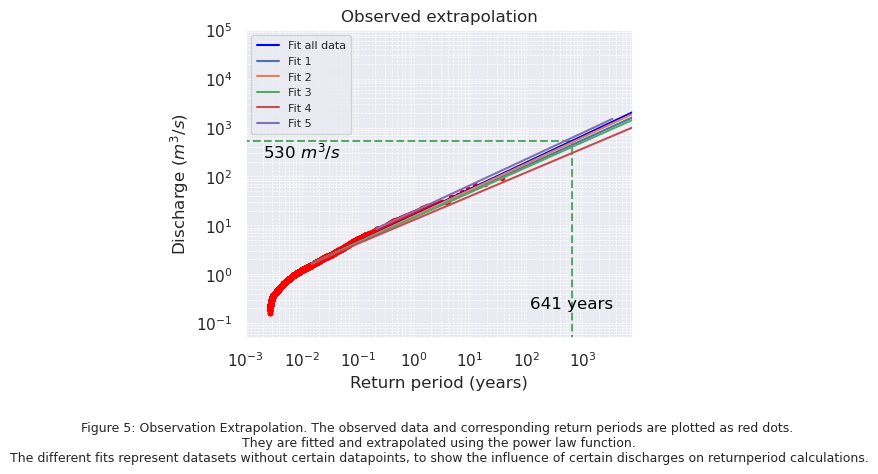

In [27]:
import scipy.stats as stats
import math
from scipy.optimize import curve_fit, fsolve
plt.figure(figsize=(5, 4))

# # discharge data > 20 m³/s
# data = [value for value in discharge if value > 20]

# all discharge data
cleaned_discharge = [x for x in discharge if not math.isnan(x)]
data = cleaned_discharge


# print(data)

# # maximum annual discharge
# data = [x for x in maxdischarge if not math.isnan(x)]
# # print(data)

# scatter of data
# Sort data from high to low
sorted_data_scatter = np.sort(data)[::-1]
sorted_data = np.sort(data)[::-1]# Sorteer aflopend
n = len(sorted_data)
rank = np.arange(1, n + 1)
return_periods_days = (n + 1) / rank
return_periods_years_scatter = return_periods_days / 365.25


def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_data):
    n = len(sorted_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25


    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_data[return_periods_years >= 0]

    # Fit the power law function
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=10000)
    a_opt, b_opt = params

    # Make fit for return period
    x_fit = np.logspace(np.log(min(sorted_data)), np.log10(max(return_periods_years_subset))*2.5, 50)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt

x_fit, y_fit, a_opt, b_opt = calculate_return_periods(sorted_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed')
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed')
plt.text(x_value, 0.2, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  
plt.text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 510
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 511
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 550
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 557
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.plot(x_fit, y_fit, label=f'Fit all data', color='blue')

sorted_data_list = [
    np.delete(sorted_data, 0),           
    np.delete(sorted_data, 1),           
    np.delete(sorted_data, [0, 1]),      
    np.delete(sorted_data, slice(0, 5)), 
    sorted_data[sorted_data >= 0.5]
]

for i, sorted_data in enumerate(sorted_data_list):
    x_fit_less, y_fit_less, a_opt, b_opt = calculate_return_periods(sorted_data)

    def find_x_for_y(y_target, a, b):
        return (y_target / a) ** (1 / b)
    y_target = 530
    x_value = find_x_for_y(y_target, a_opt, b_opt)
    # print(f"For a discharge of {y_target} m3/s, the return period is {x_value:.3f} years for fit {i + 1}")
    plt.plot(x_fit_less, y_fit_less, label=f'Fit {i + 1}')

plt.ylim(0.05, 100000)  # Kies een passend bereik
plt.xlim(0.001, 8000)
plt.yscale('log')
plt.xscale('log')
plt.scatter(return_periods_years_scatter, sorted_data_scatter, color="red", marker='.')
plt.xlabel('Return period (years)')
plt.ylabel('Discharge ($m^3/s$)')


plt.title('Observed extrapolation')
plt.legend(fontsize=8, markerscale=0.8, frameon=True, borderpad=0.5)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.5, -0.4, "Figure 5: Observation Extrapolation. The observed data and corresponding return periods are plotted as red dots. \n They are fitted and extrapolated using the power law function. \n"
         "The different fits represent datasets without certain datapoints, to show the influence of certain discharges on returnperiod calculations.", 
         ha="center", fontsize=9, transform=plt.gca().transAxes)
plt.tight_layout()
# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/scatterobs3.png", dpi=300)
plt.show();


In Figure 5 it can be seen that the presence of certain peak discharges in the data have a big influence on the extrapolation. Using all data, the key discharges from the normal distribution deterimined in Chapter 2 have the following return periods:

- 510 m\textsuperscript{3}/s: 597 years
- 511 m\textsuperscript{3}/s: 599 years
- 530 m\textsuperscript{3}/s: 641 years
- 534 m\textsuperscript{3}/s: 650 years
- 550 m\textsuperscript{3}/s: 686 years
- 557 m\textsuperscript{3}/s: 702 years

Removing the highest discharge value results in a return period of 923 years for a discharge of 530 m\textsuperscript{3}/s, removing the five highest peaks results in a return period of 2100 years for a discharge of 530 m\textsuperscript{3}/s, and removing the discharges lower than 0.5 m\textsuperscript{3}/s results in a return period of 487 years. These influences of certain discharge values on the return period calculation are important to consider when comparing the model output to the observations. 

In Figure 6 both the normal distribution of the exceedance threshold values and the extrapolated return periods are plotted. A discharge value more to the right of the normal distribution, has a higher return period, but also has a higher probability of actually causing flooding of the U4 subway line.

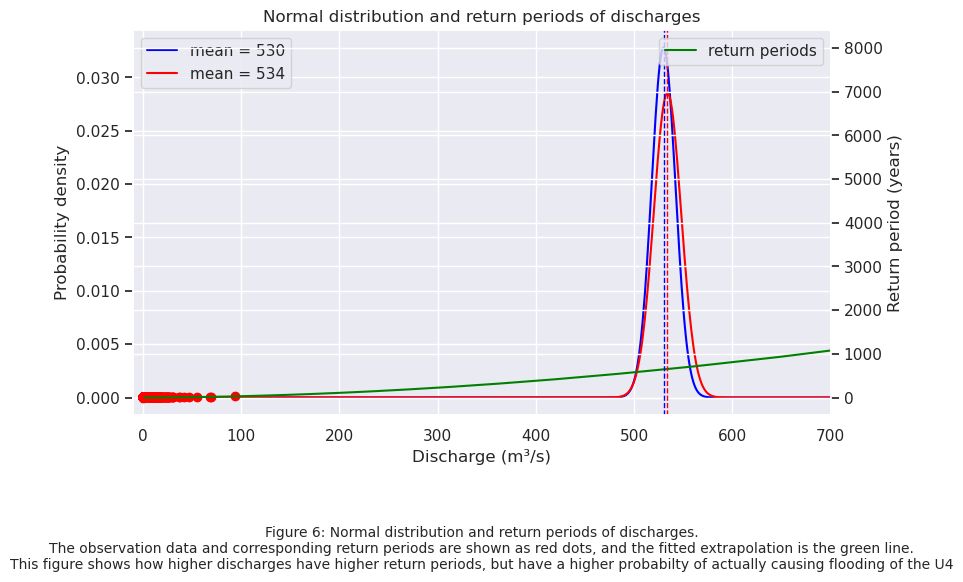

In [28]:
#1
mean = 530
p5 = 510  # 5th percentile
p95 = 550  # 95th percentile

#Calculate standard deviation
z_5 = stats.norm.ppf(0.05)  # -1.645
z_95 = stats.norm.ppf(0.95)  # 1.645
std_dev = (p95 - mean) / z_95  # σ = (550 - 530) / 1.645
x = np.linspace(0, 1100, 1000)
y = stats.norm.pdf(x, mean, std_dev)

#2
mean_2 = 534
p5_2 = 511  # 5th percentile
p95_2 = 557  # 95th percentile

#Calculate standard deviation
z_5 = stats.norm.ppf(0.05)  # -1.645
z_95 = stats.norm.ppf(0.95)  # 1.645
std_dev_2 = (p95_2 - mean_2) / z_95  # σ = (550 - 530) / 1.645
x_2 = np.linspace(0, 1100, 1000)
y_2 = stats.norm.pdf(x_2, mean_2, std_dev_2)


fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(x, y, label="mean = 530", color='blue')
ax1.plot(x_2, y_2, label="mean = 534", color='red')

ax1.set_xlabel("Discharge (m³/s)")
ax1.set_ylabel("Probability density")

# Make second axis
ax2 = ax1.twinx()

ax2.plot(y_fit, x_fit, label="return periods", color='green')
ax2.set_ylabel("Return period (years)")
ax2.tick_params(axis='y')

ax2.scatter(sorted_data_scatter, return_periods_years_scatter, color="red")

plt.title(f"Normal distribution and return periods of discharges")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.text(0.5, -0.4, "Figure 6: Normal distribution and return periods of discharges.\n"
         "The observation data and corresponding return periods are shown as red dots, and the fitted extrapolation is the green line.\n"
         "This figure shows how higher discharges have higher return periods, but have a higher probabilty of actually causing flooding of the U4", 
         ha="center", fontsize=10, transform=plt.gca().transAxes)

plt.grid(True)
ax1.set_xlim(min(sorted_data_scatter)-10, 700)  # Pas de limieten aan op basis van je data
plt.axvline(530, linestyle='--', color='blue', linewidth=1)
plt.axvline(534, linestyle='--', color='red', linewidth=1)

plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/normal.png", dpi=300)
plt.show()

## Conclusion

It can be concluded that the current return period for the mean treshold value of 530 m\textsuperscript{3}/s is 641 years, and for 534 m\textsuperscript{3}/s is 650 years. This means that the current return period of flooding is shorter than the return period the Wien River was designed for, 1000 years.  